In [29]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set the visual style for the portfolio
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

# Where your data lives
EXPERIMENT_DIR = "./experiment_data"

#Image results
IMAGE_DIR = "./results"
os.makedirs(IMAGE_DIR, exist_ok=True)

In [30]:
def load_all_data(root_dir):
    all_records = []
    
    for root, dirs, files in os.walk(root_dir):
        if "processing_stats.csv" in files and "judge_stats.csv" in files:
            
            # 1. Load Processing Stats
            proc_path = os.path.join(root, "processing_stats.csv")
            try:
                df_proc = pd.read_csv(proc_path)
                df_proc.columns = [c.lower() for c in df_proc.columns] # Force lowercase headers
            except:
                continue 
            
            # 2. Load Judge Stats
            judge_path = os.path.join(root, "judge_stats.csv")
            try:
                df_judge = pd.read_csv(judge_path)
                df_judge.columns = [c.lower() for c in df_judge.columns] # Force lowercase headers
            except:
                continue

            # --- DATA CLEANING FIX FOR DEEPFILTERNET ---
            # Remove the "_DeepFilterNet3" suffix from filenames if it exists
            # This ensures "file_DeepFilterNet3.wav" becomes "file.wav" to match the processing log
            if 'filename' in df_judge.columns:
                df_judge['filename'] = df_judge['filename'].str.replace('_DeepFilterNet3', '', regex=False)

            # --- STANDARD CLEANING ---
            
            # Rename the 4th column to 'denoised_score'
            if len(df_judge.columns) >= 4:
                method_col_name = df_judge.columns[3] 
                df_judge = df_judge.rename(columns={method_col_name: 'denoised_score'})
            
            # 3. MERGE
            if 'filename' in df_proc.columns and 'filename' in df_judge.columns:
                merged = pd.merge(df_proc, df_judge, on="filename", how="inner")
                all_records.append(merged)

    if all_records:
        final_df = pd.concat(all_records, ignore_index=True)
        return final_df
    else:
        return pd.DataFrame()

# RUN IT
df = load_all_data(EXPERIMENT_DIR)

print(f"Total processed files loaded: {len(df)}")
print("Methods found:", df['method'].unique()) 
# You should now see 'DeepFilterNet' in this list!

Total processed files loaded: 6000
Methods found: ['Demucs' 'DeepFilterNet' 'Spectral Gating' 'Wavelet' 'Wiener']


In [31]:
# --- CELL 3: Feature Engineering ---

# 1. Inspect the columns first (Just to be sure)
print("Actual DataFrame Columns:", df.columns.tolist())

# 2. Calculate Improvement
def get_baseline_score(row):
    # Note: Column names are lowercase ('-5db', '0db') from Cell 2 fix.
    # But the *data values* in 'snr_level' might still be '-5dB' or '0dB'.
    
    if row['snr_level'] == '-5dB':
        return row['-5db']  # Use lowercase 'b' for column name
    else:
        return row['0db']   # Use lowercase 'b' for column name

# Apply the function
df['baseline_score'] = df.apply(get_baseline_score, axis=1)

# Calculate the delta (Denoised - Original)
df['improvement'] = df['denoised_score'] - df['baseline_score']

# 3. Fix Processing Time (Convert ms to Seconds)
df['time_sec'] = df['processing_time_ms'] / 1000

print("✅ Feature Engineering Complete. Ready for plotting.")
print(df[['filename', 'method', 'snr_level', 'denoised_score', 'baseline_score', 'improvement']].head())

Actual DataFrame Columns: ['filename', 'category', 'snr_level', 'method', 'processing_time_ms', '0db', '-5db', 'denoised_score']
✅ Feature Engineering Complete. Ready for plotting.
                            filename  method snr_level  denoised_score  \
0  1_181_plus_2-160888-A-47_-5dB.wav  Demucs      -5dB          0.4318   
1  1_222_plus_4-161099-A-47_-5dB.wav  Demucs      -5dB          0.4486   
2   1_24_plus_3-128512-A-47_-5dB.wav  Demucs      -5dB          0.5926   
3  1_265_plus_4-251959-A-47_-5dB.wav  Demucs      -5dB          0.3267   
4   1_27_plus_5-251957-A-47_-5dB.wav  Demucs      -5dB          0.6793   

   baseline_score  improvement  
0          0.4452      -0.0134  
1          0.6401      -0.1915  
2          0.7004      -0.1078  
3          0.3052       0.0215  
4          0.4444       0.2349  


C:\Users\Solomon Nderitu\AppData\Local\Temp\ipykernel_25156\2822891803.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="method", y="time_sec", errorbar=None, palette="viridis")


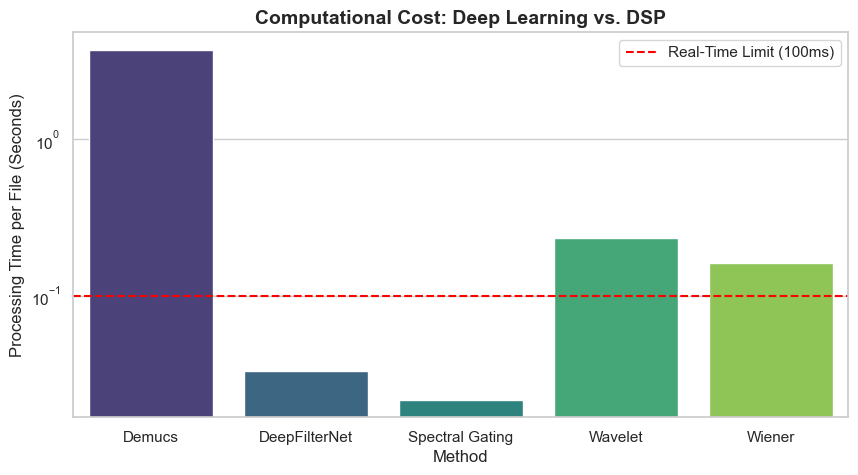

In [32]:
plt.figure(figsize=(10, 5))
# Bar chart of Time vs Method
sns.barplot(data=df, x="method", y="time_sec", errorbar=None, palette="viridis")

plt.title("Computational Cost: Deep Learning vs. DSP", fontsize=14, fontweight='bold')
plt.ylabel("Processing Time per File (Seconds)")
plt.xlabel("Method")
plt.yscale("log") # <--- SUPER IMPORTANT! Demucs is 1000x slower, Log scale makes it visible.
plt.axhline(0.1, color='red', linestyle='--', label="Real-Time Limit (100ms)")
plt.legend()

# Save the figure
plt.savefig(os.path.join(IMAGE_DIR, "computational_cost.png"))

plt.show()

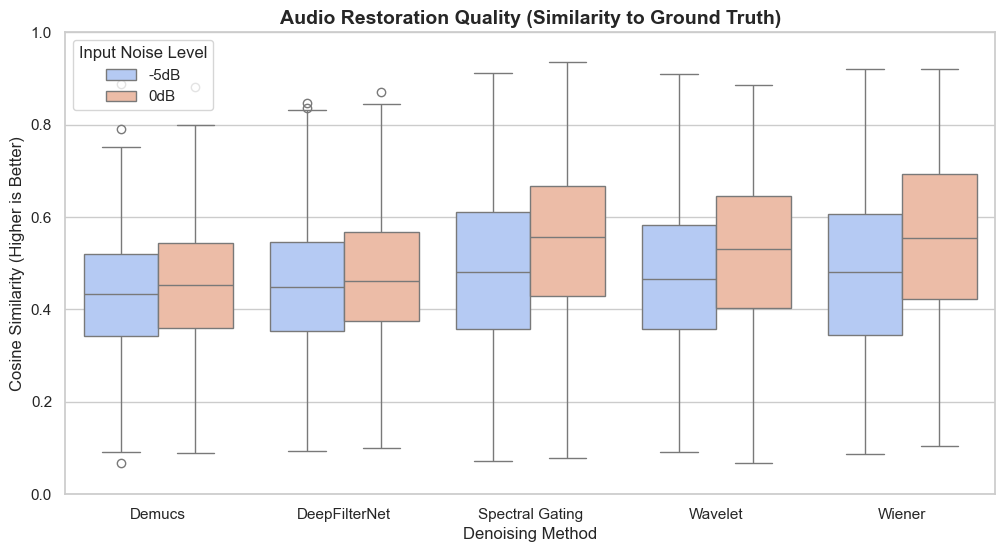

In [33]:
plt.figure(figsize=(12, 6))

# Box Plot of Denoised Scores
sns.boxplot(data=df, x="method", y="denoised_score", hue="snr_level", palette="coolwarm")

plt.title("Audio Restoration Quality (Similarity to Ground Truth)", fontsize=14, fontweight='bold')
plt.ylabel("Cosine Similarity (Higher is Better)")
plt.xlabel("Denoising Method")
plt.ylim(0, 1.0)
plt.legend(title="Input Noise Level")

# Save the figure
plt.savefig(os.path.join(IMAGE_DIR, "audio_restoration_quality.png"))

plt.show()

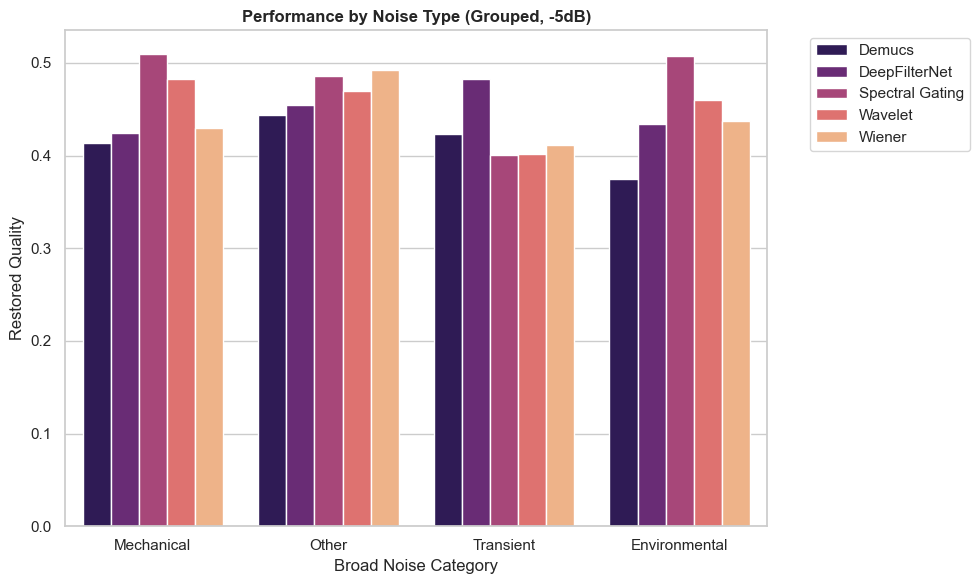

In [35]:
# 1. Define your groups (This is a sample list, you'd map all 50)
category_map = {
    'airplane': 'Mechanical',
    'engine': 'Mechanical',
    'vacuum_cleaner': 'Mechanical',
    'washing_machine': 'Mechanical',
    # ... add more ...
    'dog': 'Transient',
    'glass_breaking': 'Transient',
    'siren': 'Transient',
    # ... add more ...
    'rain': 'Environmental',
    'wind': 'Environmental',
    # ... etc ...
}

# Function to apply mapping safely
def map_category(cat_name):
    # Returns 'Other' if the category isn't in your map yet
    return category_map.get(cat_name, 'Other') 

# 2. Create the new column
df['category_group'] = df['category'].apply(map_category)

# 3. Plot using the new group
plt.figure(figsize=(10, 6))
sns.barplot(data=df[df['snr_level'] == '-5dB'], 
            x="category_group", 
            y="denoised_score", 
            hue="method", 
            palette="magma",
            errorbar=None) # Remove error bars for cleaner look

plt.title("Performance by Noise Type (Grouped, -5dB)", fontweight='bold')
plt.ylabel("Restored Quality")
plt.xlabel("Broad Noise Category")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(IMAGE_DIR, "performance_by_category_group.png"))

plt.show()